This script does all the logistic regression stuff using all of the data.
It:
- goes through all assumptions for logistic regression
- alters the data wherever necessary to make things work
- creates a classifier and evaluates its performance

### Data Loading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
if True:
    df = df.sample(math.floor(len(df) * 0.1))
    print((5 * "#########\n") +
          "YOU'RE USING A RANDOM SUBSAMPLE OF 10%!!!\n" + (5 * "#########\n"))
print(df.columns)

# Loads first-time contributor data frame.
ftc_df = df[df[ftc_key]]
print(f'{len(df)=}')
print(f'{len(ftc_df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

# Removes fields with only columns from ftc dataset.
ftc_columns_old = ftc_df.columns
ftc_df = ftc_df.loc[:, (ftc_df != 0).any()]
ftc_columns_new = ftc_df.columns
ftc_removed = [field for field in ftc_columns_old
               if field not in ftc_columns_new]
print(f'{ftc_removed=}')

df[independent_fields].describe()


#########
#########
#########
#########
#########
YOU'RE USING A RANDOM SUBSAMPLE OF 10%!!!
#########
#########
#########
#########
#########

Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSub

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In)),ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSubmitter-In)),ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-In)),ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToCommenter-In)),...,ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)
count,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,...,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000,122461.000000
mean,0.501359,0.403772,0.096662,0.058340,6.435174,1.089904,0.463168,0.465481,0.436574,0.344895,...,1.012107,0.147291,0.087899,0.390236,0.672489,1.291447,0.066305,0.131512,0.061666,0.134269
std,0.471102,0.452462,0.288227,0.226977,3.450762,0.656910,0.992629,0.999619,1.056637,0.917528,...,1.491204,0.495242,0.400205,1.058385,0.963206,1.619327,0.316208,0.539980,0.341441,0.637273
min,0.000000,0.000000,0.000000,0.000000,0.016529,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.636270,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.666667,0.000000,0.000000,0.000000,6.795351,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.941176,0.000000,0.000000,8.967328,1.386294,0.693147,0.693147,0.000000,0.000000,...,1.791759,0.000000,0.000000,0.000000,1.098612,2.302585,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,15.176289,9.129998,12.404202,10.615285,11.568218,11.187098,...,7.334982,5.267858,5.332719,9.813016,5.924256,7.518064,5.924256,6.788972,5.924256,6.915723


### Log-odds independence

In [2]:
import json
from numbers import Number
from typing import Callable
import numpy as np
import statsmodels.api as sm


def box_tidwill_test(__independents: pd.DataFrame,
                     var_transform: Callable[[Number], Number]):
    continuous_vars = __independents.select_dtypes(include='number')
    continuous_copy = continuous_vars.copy()

    failed = []

    for field in continuous_copy.columns:
        # Drops zeroes.
        rows_with_zeroes = continuous_copy.loc[continuous_copy[field] == 0].index
        independents_wo_zeroes = continuous_copy.drop(rows_with_zeroes)
        test_dependent = df[pr_merged_key].drop(rows_with_zeroes)

        # Selects and transforms fields.
        test_independents = pd.DataFrame()
        test_independents[field] = independents_wo_zeroes[field]\
            .apply(var_transform)
        ln_field = f'ln(.) x {field}'
        test_independents[ln_field] = test_independents[field]\
            .apply(lambda x: np.log(x) * x)

        # Adds constant
        test_independents = sm.add_constant(test_independents)

        # Does the test.
        logit_results = sm.GLM(test_dependent,
                               test_independents,
                               family=sm.families.Binomial()).fit()

        p_value = logit_results.pvalues[ln_field]
        if p_value < 0.05:
            failed.append(field)

        is_significant = "significant" if p_value < 0.05 else "insignificant"

        print(f'({is_significant}) {field}: p={p_value} (used {len(independents_wo_zeroes)}/{len(continuous_copy)} entries).')

    return failed


failed = box_tidwill_test(df[independent_fields], lambda x: x)

print()
print(f'{len(failed)=}')
print(f'{failed=}')


(significant) IntraProjectSubmitterPullRequestSuccessRate: p=4.9738164199084444e-26 (used 66829/122461 entries).
(significant) EcosystemExperienceSubmitterPullRequestSuccessRate: p=1.380743463868417e-08 (used 56654/122461 entries).
(significant) DependencyEcosystemExperienceSubmitterPullRequestSuccessRate: p=0.0012073619940121566 (used 12628/122461 entries).
(insignificant) InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate: p=0.16551569258835486 (used 7756/122461 entries).
(significant) ln(1 + ControlPullRequestLifeTimeInMinutes): p=0.0 (used 122461/122461 entries).
(significant) ln(1 + ControlNumberOfCommitsInPullRequest): p=1.186510686233287e-72 (used 122228/122461 entries).
(insignificant) ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In)): p=0.18450768511422455 (used 37060/122461 entries).
(insignificant) ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSubmitter-In)): p=0.6856078433356614 (used 35762/

In [3]:
from scipy.stats import yeojohnson


df_failed = df[failed].copy()
print(f'{len(df_failed)=}')

transformations = [
    math.sqrt,
    math.cbrt,
    lambda x: math.log(1 + x),
    lambda x: math.log10(1 + x),
    lambda x: 1 / x,
    lambda x: x**2,
    lambda x: x**3,
]

for transformation in transformations:
    print(transformation)
    try:
        box_tidwill_test(df_failed, transformation)
    except:
        ...
    print()

print("Yeo-Johnson")
for field in failed:
    df_failed[field], _lambda = yeojohnson(df_failed[[field]])
    print(f'{field}: {_lambda=}')
print()
box_tidwill_test(df_failed, lambda x: x)

# IntraProjectSubmitterPullRequestSuccessRate                                       (cbrt)
# FirstOrderDegreeCentrality(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In)    (ln, log10, squared)
# EcosystemExperienceSubmitterPullRequestSuccessRate                                (ln, log10)
# IntraProjectSubmitterPullRequestCommentCount                                      (recip)
# IntraProjectSubmitterPullRequestSubmissionCount                                   (squared)
# EcosystemExperienceSubmitterIssueCommentCount                                     (cubed)
# EcosystemExperienceSubmitterIssueSubmissionCount                                  (yj)


len(df_failed)=122461
<built-in function sqrt>


(significant) IntraProjectSubmitterPullRequestSuccessRate: p=0.00019273403389693025 (used 66829/122461 entries).
(insignificant) EcosystemExperienceSubmitterPullRequestSuccessRate: p=0.40079777492989277 (used 56654/122461 entries).
(significant) DependencyEcosystemExperienceSubmitterPullRequestSuccessRate: p=0.046945641567506156 (used 12628/122461 entries).
(significant) ln(1 + ControlPullRequestLifeTimeInMinutes): p=0.0 (used 122461/122461 entries).
(significant) ln(1 + ControlNumberOfCommitsInPullRequest): p=2.5068890982762995e-73 (used 122228/122461 entries).
(significant) ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-In)): p=2.6697149323666204e-06 (used 26818/122461 entries).
(significant) ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToCommenter-In)): p=0.0017335429465650167 (used 23641/122461 entries).
(significant) ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.IssueCommenterToSubmitter-In)): p=0.0003811098

['IntraProjectSubmitterPullRequestSuccessRate',
 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
 'ln(1 + ControlPullRequestLifeTimeInMinutes)',
 'ln(1 + ControlNumberOfCommitsInPullRequest)',
 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-In))',
 'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToCommenter-In))',
 'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.IssueCommenterToSubmitter-In))',
 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-Out))',
 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-Out))',
 'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToSubmitter-Out))',
 'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToCommenter-Out))',
 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
 'ln(1 + IntraProj

### Multicolinearity

In [4]:
multicollinear_fields = [
    # ### Cluster: if it has comments, it will commonly have a comment from an external user as well?
    # 'ControlPullRequestHasCommentByExternalUser',
    "ControlPullRequestHasComments",

    # ### Cluster: PR submitters receive comments.
    # "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRIntegratorToSubmitter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToSubmitter-In))",

    # Almost all of the shared experience fields correlate directly with each other.
    # 3/7 correlate with everything, 2 with everything - 1, and 2 with fewer than that.
    # They discussed stuff in issues correlates with: pull requests submitted
    # and commenting/disc. participation (in either direction) on PRs and issues;
    # i.e., if people cooperate, they cooperate across the board.


    # ### Cluster: Shared experience; i.e., people work together.
    # "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)", 
    "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
    # "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)",
    "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",
    "ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",



    # ### Cluster: Issue comments
    # Com-com in and out correlation makes sense as it's a many-to-many relationship, so there's always a
    # reciprocating edge. It also makes sense that this correlates with commenter to submitter as when they
    # participate in a discussion, they automatically add an edge to the submitter.
    # "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.IssueCommenterToSubmitter-Out))", corr. with 2
    # corr. with 2
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.IssueCommenterToCommenter-In))",
    # corr. with 2
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.IssueCommenterToCommenter-Out))",


    # ### Cluster: Inversed dependencies - pulls and issues.
    # All of their coeficients are positive, so more pulls = more acceptance =
    # more issues = more comments in the ecosystem.
    # All of them correlate with the others, so we can keep only 1.
    # "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)", # corr with 4
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate", 
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",

    # ### Cluster: PR commenters.
    # Same logic applies here as with the issues, in and out are bound to be the same, and
    # commenting on a PR by definition means an outgoing edge to the submitter.
    # Its a fully connected cluster, so we can only keep one.
    # "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.PRCommenterToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.PRCommenterToCommenter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.PRCommenterToCommenter-Out))",

    # ### Cluster: Same logic as the other commenter clusters.
    # "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.PRCommenterToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.PRCommenterToCommenter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.PRCommenterToCommenter-Out))",

    # ### Cluster: Whenever there's an issue posted, the submitter responds themselves, and if there
    # are multiple participating parties, they'll always get an edge of both.
    # "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.IssueCommenterToSubmitter-In))"
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.IssueCommenterToCommenter-In))",

    # ### Cluster: Integrators comment on their integrated PRs.
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.PRIntegratorToSubmitter-Out))",
    # "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.PRCommenterToSubmitter-Out))",

    # ### Cluster: integrators comment on PRs.
    # "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.PRIntegratorToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.PRCommenterToSubmitter-Out))",

    # ### Cluster: integrators comment on PRs.
    # "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.PRIntegratorToSubmitter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.PRCommenterToSubmitter-In))",

    # ### Cluster: Classic commenter correlation.
    # "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.IssueCommenterToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.IssueCommenterToCommenter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.IssueCommenterToCommenter-Out))",

    # ### Cluster: Integrator comments on prs they integrate.
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.PRIntegratorToSubmitter-In))",
    # "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToSubmitter.PRCommenterToSubmitter-In))",

    # ### Cluster: Integrator comments to submitters.
    # This is not a trivial fully connected cluster. These three nodes
    # form a bridge between two clusters.
    # "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.PRIntegratorToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRIntegratorToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.PRCommenterToSubmitter-Out))",

    # ### Cluster: commenting on your own PRs triggers a response.
    # "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.PRIntegratorToSubmitter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.PRCommenterToSubmitter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.PRCommenterToCommenter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.PRCommenterToCommenter-In))",

    # ### Cluster: Participating in comments cluster.
    # "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToCommenter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToCommenter-Out))",

    # ### Cluster: commenter cluster.
    # "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.IssueCommenterToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.IssueCommenterToCommenter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.IssueCommenterToCommenter-Out))",

    # ### Cluster: Not a cluster; it's a line.
    # This suggest there's some overlap in participating in your own discussions and receiving responses.
    # "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.IssueCommenterToSubmitter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.IssueCommenterToSubmitter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.IssueCommenterToCommenter-Out))",
    # "ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.IssueCommenterToSubmitter-Out))",

    # ### Cluster: Not a cluster, but these two form a bridge between two clusters.
    # This relation makes complete sense as if you submit PRs in the dependency ecosystem,
    # you submit them in the general ecosystem too. There's no reason to pick either, however,
    # Ecosystem exp has more data to it.
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",

    # ### CLuster: In the ecosystem, commenting on issues and PRs correlates with
    # Issue submission counts and PR success rate.
    # "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",
    # "EcosystemExperienceSubmitterPullRequestSuccessRate",

    # ### Cluster: Dependency ecosystem experience.
    # All of these are positively correlated; i.e., if you do more you do more and better.
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate", # corr. with 3 (PR sub, PR com, Issue comm)
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)", # corr. with 4
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)", # corr. with 4
    # "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)", # corr. with 3
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)", # corr with 4

    # ### Cluster Pr Success rate correlates with FTC (which I didn't want to include like this anyways),
    # and the more PR submissions you do and more PR comments you give, the worse you perform.
    # "IntraProjectSubmitterPullRequestSuccessRate",
    "SubmitterIsFirstTimeContributor",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    # "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",


    # ### Cluster: PR submitters get comments from their integrators.
    #  
    # "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSubmitter-In))",

    "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-In))",
    # "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-Out))",
    
    # People who comment on PRs comment on issues.
    "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSubmitter-Out))",
    # "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToSubmitter-Out))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToCommenter-In))",
    "ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToCommenter-Out))",
]

print(f'{len(multicollinear_fields)=}')


len(multicollinear_fields)=55


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}
    
    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df

tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]


In [6]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print("Problematic VIF scores:")
print(problematic_vif)

Problematic VIF scores:
Empty DataFrame
Columns: [variable, VIF]
Index: []


coof_threshold=0.5
Correlating pairs:
[]

Variable correlation frequency:
[]

Transitive closure of correlating pairs:
[
    []
]


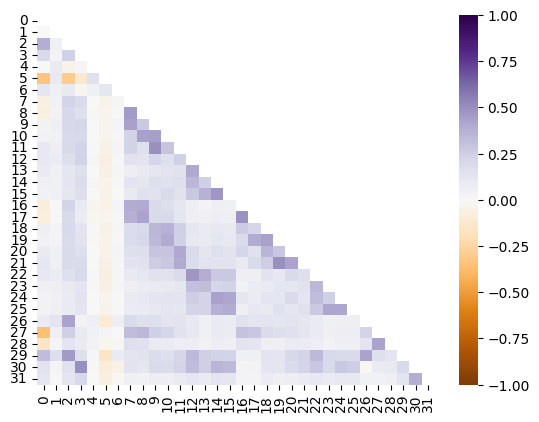

In [55]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr()

rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append('red' if coof < 0 else 'green')

    # Create an empty graph
    graph = nx.Graph()    


    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)
    plt.show()

    print(json.dumps(enumerated_list))


In [9]:
print(tested_predictors.columns)

Index(['ControlIntegratedBySameUser', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRIntegratorToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.IssueCommenterToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToCommenter.PRIntegratorToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(IssueCommenterToCommenter.PRIntegratorToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(IssueCommen